In [19]:
# Code based on GuitarLSTM by Keith Bloemer:
# https://github.com/GuitarML/GuitarLSTM

import numpy as np
import pandas as pd
import scipy
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from keras import models
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf

import math
import os
import soundfile as sf
import time
import random

import data

%matplotlib inline
%config IPCompleter.greedy=True

In [20]:
# Main parameters
sr = 22050

# Choose which effect to model
effect = "Distortion"

# Size of frame (in samples) that is fed to the model during training
frame = 64
# Chunk == sample
chunk = 1

# Duration of data in seconds
duration = 120

# Type of input; sequential or random frame order
sequential_input = False

if sequential_input==True:
    shuffle_state = False
elif sequential_input==False:
    shuffle_state = True

# Model name for saving the model
model_name_save = 'csc475_baseline_1'

# If dual_layer is True then the model will have 2 layers of LSTM
dual_layer=False

# Number of hidden units in the lstm layer
hidden_units = 16

# Batch size for training
batch_size_para = 64

# Epochs during training
epochs_ = 50

# Choose which test file segment to inspect visually
# Between 0 and 5 for default 2 minute duration
index_number = 4

In [21]:
# Disabling GPU for Mac M1 chips running tensorflow metal, do not use if not on Mac with M1 chip. 
# (RNNs run slowly on GPU)
tf.config.experimental.set_visible_devices([], 'GPU')

In [23]:
# Building the dataset

# Loading the dry and wet audio
signal, wet = data.create_data(effect, "metadata,csv", mu_comp=False, srate=sr, 
                               duration=duration, type="random")

# Size of frames in training dataset
training_dataset_ = (int) ((len(signal) / frame) * 0.8)

# Size of frames for testing (not the proper testset, details below)
testing_dataset_ = (int) ((len(signal) / frame) * 0.2)

# Wether to filter the audio
filtered = False

# Creating a high pass filter 

numtaps = 91
cutoff = 0.015
b = scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero='highpass')

# Creating a lowpass filter

numtaps = 41
cutoff = 0.92

b2 = scipy.signal.firwin(numtaps, cutoff, width=None, window='hamming', pass_zero='lowpass')

# Optionally high pass audio to emphasize high frequency information, low pass to avoid aliasing artifacts
if filtered is True:
    # High Pass Filter
    signal = scipy.signal.lfilter(b, 1, signal)
    wet = scipy.signal.lfilter(b, 1, wet)
    # Low Pass Filter
    signal = scipy.signal.lfilter(b2, 1, signal)
    wet = scipy.signal.lfilter(b2, 1, wet)

In [24]:
print('Comparing the original dry audio to the wet audio as a reference' )
print('Mean absolute error: %.4f'% metrics.mean_absolute_error(signal, wet))
print('Mean squared error: %.4f'% metrics.mean_squared_error(signal, wet))
print('Coefficient of determination (R2 score): %.4f'% metrics.r2_score(signal, wet))

Comparing the original dry audio to the wet audio as a reference
Mean absolute error: 0.0523
Mean squared error: 0.0044
Coefficient of determination (R2 score): -51.1937


In [25]:
def create_dataset(input_file, output_file, size_training, size_test, frame, sr=sr):
    
    signal = input_file
    wet = output_file
    
    # Creating the foundation of the dataset by splitting the whole audio into 5 seconds segments
    segment_size = sr * 5
    dry_segments = np.zeros((int(signal.size/segment_size), segment_size))
    wet_segments = np.zeros((int(signal.size/segment_size), segment_size))
    counter = 0

    for i in range(0, signal.size-segment_size-1, segment_size):
                
        dry_segment = signal[i:i+segment_size]
        
        wet_segment = wet[i:i+segment_size]

        dry_segments[counter,:], wet_segments[counter,:] = dry_segment, wet_segment
        counter+= 1

    # Splitting the segments into the training and testing set
    dry_train, dry_test, wet_train, wet_test = train_test_split(dry_segments, wet_segments, test_size=0.2, random_state=5)


    # Creating the training set (randomly pulling frames and target value from all segments in train set)

    features_train = np.zeros((size_training, frame))
    targets_train = np.zeros((size_training))
    counter = 0

    for i in range(size_training):
        random_index = random.randint(0,dry_train.shape[0]-1)
        dry_slice = dry_train[random_index]
        wet_slice = wet_train[random_index]
        random_start = random.randint(0,segment_size-frame-2)
        features = dry_slice[random_start:random_start+frame]
        target = wet_slice[random_start+frame-1]
        features_train[counter,:], targets_train[counter] = features, target
        counter += 1

    # Creating the testing set (randomly puling frames and target value from segments in test set)

    features_test = np.zeros((size_test, frame))
    targets_test = np.zeros((size_test))
    counter = 0
    for i in range(size_test):
        random_index = random.randint(0,dry_test.shape[0]-1)
        dry_slice = dry_test[random_index]
        wet_slice = wet_test[random_index]
        random_start = random.randint(0,segment_size-frame-2)
        features = dry_slice[random_start:random_start+frame]
        target = wet_slice[random_start+frame-1]
        features_test[counter,:], targets_test[counter] = features, target
        counter += 1

    return dry_test, wet_test, features_train, features_test, targets_train, targets_test    

In [26]:
def create_sequential_dataset(input_file, output_file, size_training, size_test, frame, sr=sr):
    
    signal = input_file
    wet = output_file
    
    # Creating the foundation of the dataset by splitting the whole audio into 5 seconds segments
    segment_size = sr * 5
    dry_segments = np.zeros((int(signal.size/segment_size), segment_size))
    wet_segments = np.zeros((int(signal.size/segment_size), segment_size))
    counter = 0

    for i in range(0, signal.size-segment_size-1, segment_size):
                
        dry_segment = signal[i:i+segment_size]
        
        wet_segment = wet[i:i+segment_size]

        dry_segments[counter,:], wet_segments[counter,:] = dry_segment, wet_segment
        counter+= 1

    # Splitting the segments into the training and testing set
    dry_train, dry_test, wet_train, wet_test = train_test_split(dry_segments, wet_segments, test_size=0.2, random_state=5)

    
    # Creating the training set (pulling frames in sequence from training and testing segments)
    train_frames_pr_segment = int(size_training / dry_train.shape[0])
    test_frames_pr_segment = int(size_test / dry_test.shape[0])

    features_train = np.zeros((size_training, frame))
    targets_train = np.zeros((size_training))
    counter = 0

    for i in range(0,dry_train.shape[0]):
        dry_segment = dry_train[i]
        wet_segment = wet_train[i]
        random_start = random.randint(0,dry_segment.size-train_frames_pr_segment-frame-1)
        for x in range(0+frame, train_frames_pr_segment+frame-2):
            start_point = x + random_start      
            features = dry_segment[start_point:start_point+frame]
            target = wet_segment[start_point+frame-1]
            
            features_train[counter,:], targets_train[counter] = features, target
            counter+= 1

    # Creating the testing set (sequentiually pulling frames and target value from segments in test set)
    features_test = np.zeros((size_test, frame))
    targets_test = np.zeros((size_test))
    counter = 0
    for i in range(0,dry_test.shape[0]):
        dry_segment = dry_test[i]
        wet_segment = wet_test[i]
        random_start = random.randint(0,dry_segment.size-test_frames_pr_segment-frame-1)
        
        for x in range(0+frame, test_frames_pr_segment+frame-1):
            start_point = x + random_start      
            features = dry_segment[start_point:start_point+frame]
            target = wet_segment[start_point+frame-1]
            
            features_test[counter,:], targets_test[counter] = features, target
            counter+= 1 
            
    return dry_test, wet_test, features_train, features_test, targets_train, targets_test

In [27]:
# Executing the create_dataset function
if sequential_input==False:
    dry_test, wet_test, features_train, features_test, targets_train, targets_test = create_dataset(signal, wet, training_dataset_, testing_dataset_, frame)
elif sequential_input==True:
    dry_test, wet_test, features_train, features_test, targets_train, targets_test = create_sequential_dataset(signal, wet, training_dataset_, testing_dataset_, frame)

length_in_seconds = features_train.size / sr
length_for_wet = targets_train.size / sr
print('Length of training dry audio is {} seconds'.format(length_in_seconds)) 
print('Length of training wet audio is {} seconds'.format(length_for_wet))

Length of training dry audio is 96.0 seconds
Length of training wet audio is 1.5 seconds


In [28]:
'''Functions used later in the notebook'''
def myFIRFiltResponse(b,title, sr, a=1): 
    #sns.set_theme()
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot((w/math.pi)*sr, np.log10(np.abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

def prepare_audio(filename, sr, dur, offset):
    audio, dummy = librosa.load(filename, sr=sr, mono=True, duration=dur, offset=offset )
    counter = 0
    
    audio = np.pad(audio, (frame-1,0))
    
    results = np.zeros((audio.size, frame))
    for i in range(0+frame,audio.size-frame-1):
        
            segment = audio[i-frame:i]
            

            results[counter,:] = segment
            counter+= 1
    
    return results

def prepare_audio_seq(dry_test, index):
    '''Function to prepare audio for the model to predict, as the model expects 
    the input of sequentially ordered frames.'''
    audio = dry_test[index]
    counter = 0
    audio = np.pad(audio, (frame-1,0))
    audio = audio[0:audio.size-frame+1]
    results = np.zeros((audio.size, frame))
    for i in range(0+frame,audio.size-frame-1):
        
            segment = audio[i-frame:i]
            results[counter,:] = segment
            counter+= 1
    
    return results

def mySpectrogram(s,sr,title):
    #sns.set_theme()
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,title):
    plt.figure(figsize=(14, 3))
    plt.plot(s)
    plt.title(title)
    plt.show()

def compare_waveforms(original, predicted, true_output, title, start,stop):
    '''Simple function to plot three waveforms for comparing'''
    plt.figure(figsize=(16,6))
    plt.plot(original[start:stop])
    plt.plot(predicted[start:stop])
    plt.plot(true_output[start:stop])
    plt.legend(['original', 'predicted', 'true output'])
    plt.title(title)
    plt.show()

# Constructing the model


In [29]:
# This line clears the memory of the model being used in the notebook enabling quick experiments without changing
# the name of the model. 
tf.keras.backend.clear_session()

# Creating the model with either one or two layers based on the dual_layer Boolean value. 
model = tf.keras.Sequential(name=model_name_save)
    
model.add(tf.keras.layers.Input(shape=(frame, chunk)))
    
if dual_layer==True:    
    model.add(tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=True, name='layer1'+model_name_save))
    model.add(tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=False, name= 'layer2'+model_name_save))
else:
    model.add(tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=False, name='layer'+model_name_save))
    
model.add(tf.keras.layers.Dense(1)) 
 
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= 'mean_absolute_error')

Model: "csc475_baseline_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layercsc475_baseline_1 (LSTM)   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

TIP: Try with a model using a dataset of 40000 frames and 50 epochs to shorten the training time. Results should still be ok. 

Epoch 1/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0477 - val_loss: 0.0341
Epoch 2/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 3/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0335 - val_loss: 0.0329
Epoch 4/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0332 - val_loss: 0.0325
Epoch 5/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0326 - val_loss: 0.0328
Epoch 6/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0326 - val_loss: 0.0301
Epoch 7/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0292 - val_loss: 0.0268
Epoch 8/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0254 - val_loss: 0.0232
Epoch 9/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0223 - val_loss: 0.0205
Epoch 10/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 11/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0181 - val_loss: 0.0164
Epoch 12/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 

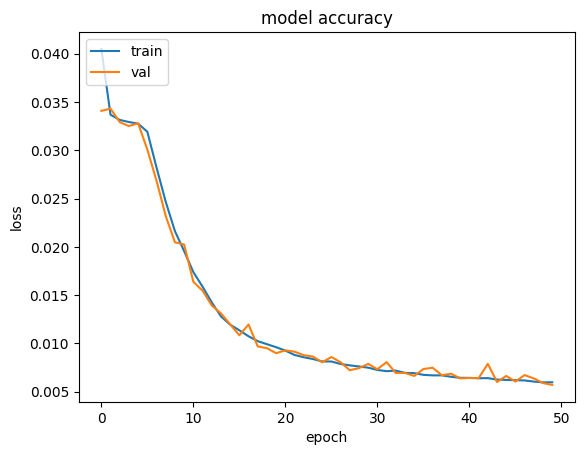

In [30]:
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    features_train,
    targets_train,
    
    batch_size=batch_size_para,
    shuffle=True,
    epochs=epochs_,
    callbacks = [callback_stop],
    validation_split = 0.15,
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Mean squared error: 0.00010991458933554281
Mean absolute error: 0.0059
Median absolute error: 0.0022
Coefficient of determination (R2 score): 0.9792
Explained variance score: 0.9793


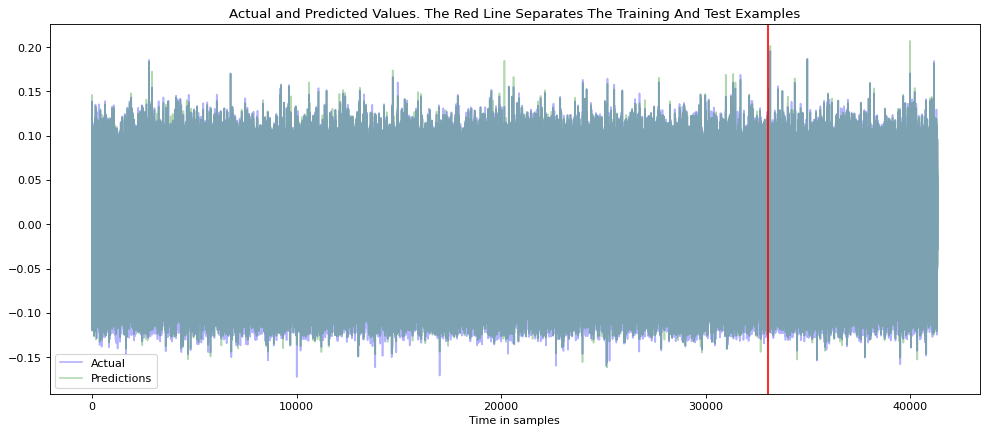

In [31]:
tar_pred = model.predict(features_test)
train_tar_pred = model.predict(features_train)

# Evaluating the training process

#mean squared error (lower the better)
print('Mean squared error: {}'.format(metrics.mean_squared_error(targets_test, tar_pred)))

#mean absolute error (lower the better)
print('Mean absolute error: %.4f'% metrics.mean_absolute_error(targets_test, tar_pred))

#median absolute error (lower the better)
print('Median absolute error: %.4f'% metrics.median_absolute_error(targets_test, tar_pred))

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (R2 score): %.4f'% metrics.r2_score(targets_test, tar_pred))

#explained variance score: 1 is perfect prediction (it can get arbitrary worse)
print('Explained variance score: %.4f'% metrics.explained_variance_score(targets_test, tar_pred))

def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual, alpha=0.3, color='blue')
    plt.plot(range(rows), predictions, alpha=0.3, color='green')
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time in samples')
    plt.ylabel('')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    
plot_result(targets_train, targets_test, train_tar_pred, tar_pred)

In [32]:
# Saving the model (ignore warnings)
model.save(os.path.join('dataset', 'models',model_name_save + '.keras'))

3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Inference of 5 Seconds of audio took 11.131196022033691 seconds with a samplerate of 22050


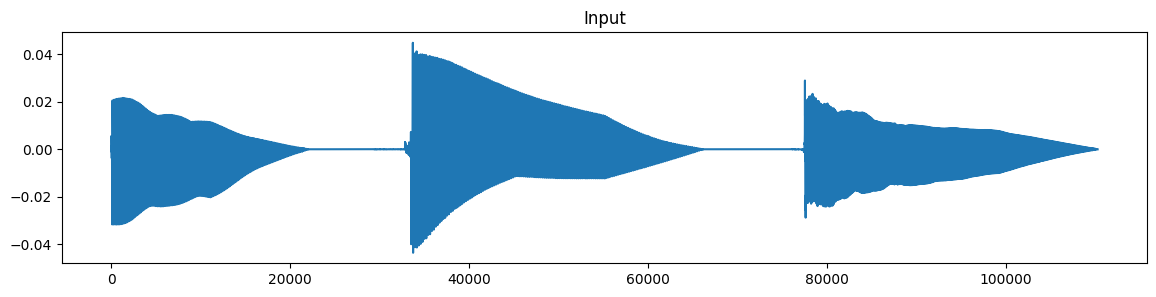

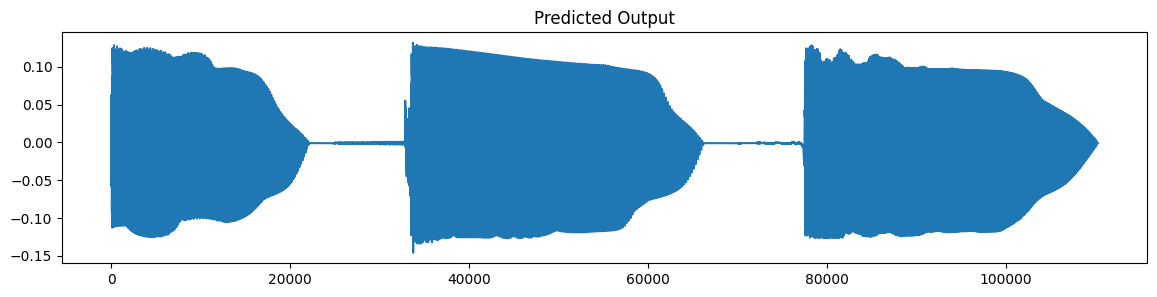

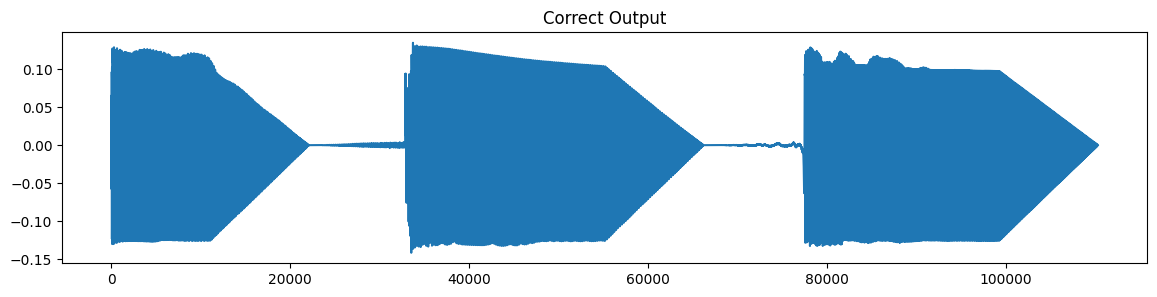

In [33]:
index=index_number

start = time.time()
prepared_audio = prepare_audio_seq(dry_test, index=index)
testfile = model.predict(prepared_audio)
#testfile = loaded_model.predict(prepared_audio)
testfile = testfile.flatten()

stop = time.time()
inference = stop - start 
print('Inference of 5 Seconds of audio took {} seconds with a samplerate of {}'.format(inference, sr))

original = dry_test[index]
original_wet = wet_test[index]

# Uncomment ipd statements to listen
myWaveform(original, 'Input')
# ipd.display(ipd.Audio(original, rate=sr))

myWaveform(testfile, 'Predicted Output')
# ipd.display(ipd.Audio(testfile, rate=sr))

myWaveform(original_wet, 'Correct Output')
# ipd.display(ipd.Audio(original_wet, rate=sr))

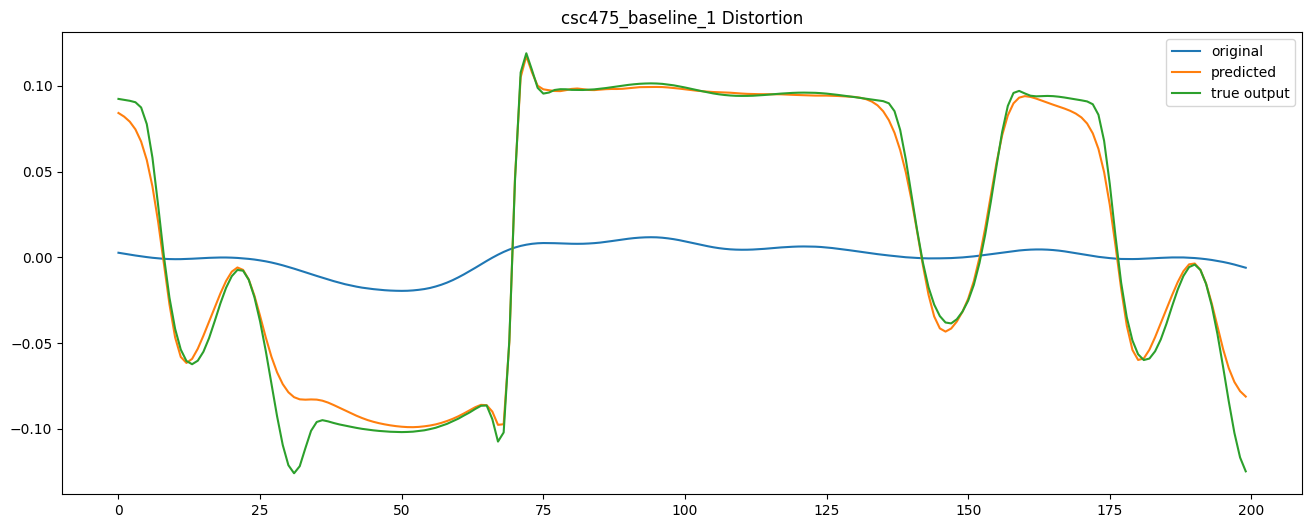

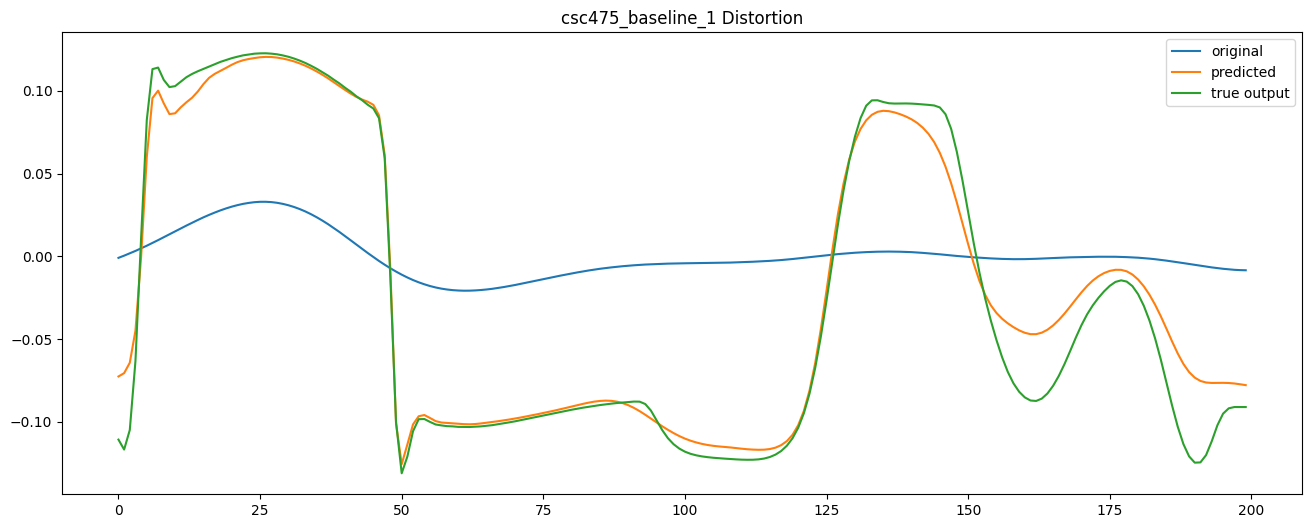

In [37]:
# Comparing short segments of the waveforms of the dry audio, predicted audio and the target wet audio
compare_waveforms(
    original, 
    testfile, 
    original_wet, 
    model_name_save + ' ' + effect, 
    10000, 
    10200
    )

compare_waveforms(
    original, 
    testfile, 
    original_wet, 
    model_name_save + ' ' + effect, 
    40000, 
    40200
    )

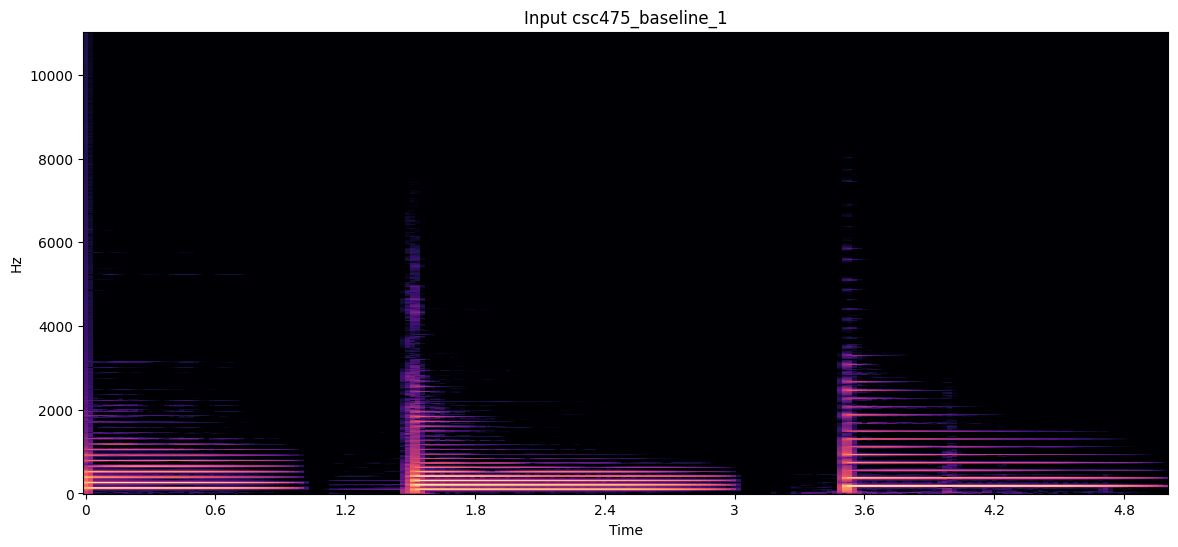

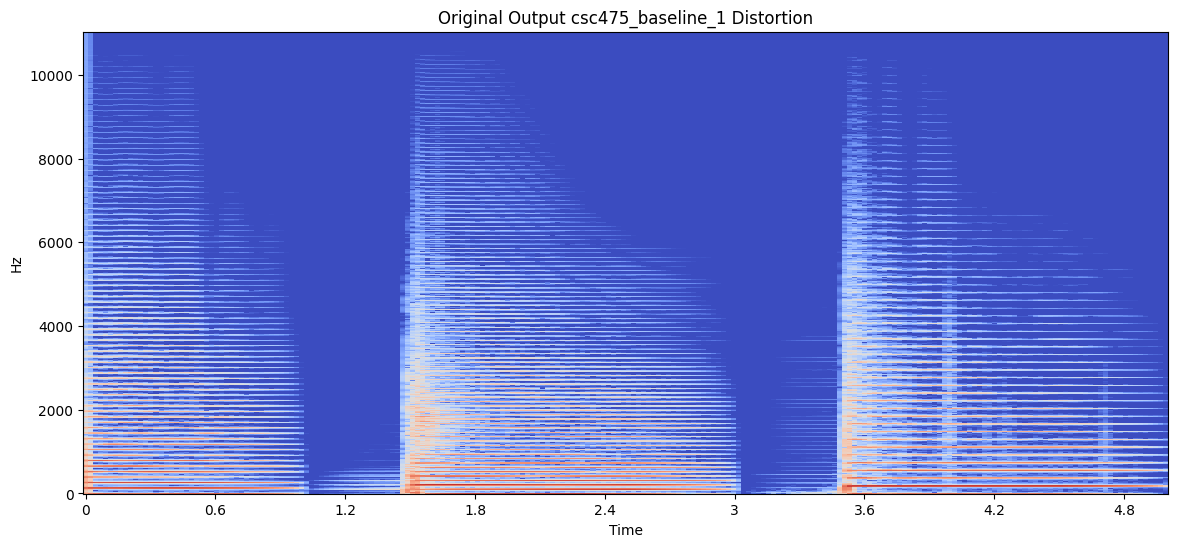

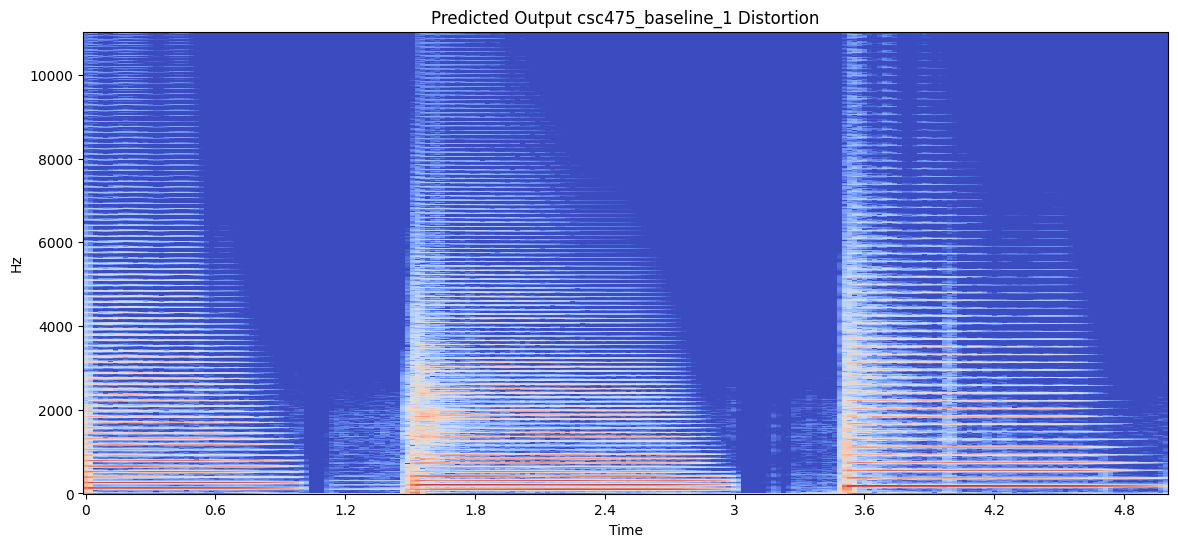

In [38]:
# Viewing spectrograms set to showing hz with no mel or log scale, to inspect high frequencies.
def mySpectrogram_hz(s,sr,title, style):
    #sns.set_theme()
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(DdB[0:1800], sr=sr, x_axis='time', y_axis=style)
    plt.title(title)
    plt.show()

mySpectrogram_hz(original, sr, 'Input ' + model_name_save, 'hz')
mySpectrogram_hz(original_wet, sr, 'Original Output ' + model_name_save + ' ' + effect, 'hz')
mySpectrogram_hz(testfile, sr, 'Predicted Output ' + model_name_save + ' ' + effect, 'hz')

In [41]:
def model_description(model):
    print(model.summary())
    print(model_name_save)
    print('The effect modeled: {}'.format(effect))
    print('Size of input audio frame is {}'.format(frame))
    print('Total length of audio in training dataset: {} seconds'.format(features_train.size / sr))
    print('Total number of frames in the training set: {}'.format(features_train.shape[0]))
    print('Number of epochs: {}'.format(epochs_))
    print('Batch size during training: {}'.format(batch_size_para))
    print('Sequential input: {}'.format(sequential_input))

def energy_normalized_mae(true, predicted):
    y_true = true / np.max(true)
    y_pred = predicted / np.max(predicted)
    return metrics.mean_absolute_error(y_true, y_pred)

def ESR(true, predicted):
    return np.sum(np.square(np.abs(true-predicted))) / np.sum(np.square(np.abs(true)))

def normalized_ESR(true, predicted):
    true = true / np.max(true)
    predicted = predicted/np.max(predicted)
    return np.sum(np.square(np.abs(true-predicted))) / np.sum(np.square(np.abs(true)))

def avg_metrics_on_predictions(k_fold=5, randomized=False):
    '''Function to compute metrics on multiple segments of the test set. k_fold determines how many
    segments are analysed. If random is set to false, it will compute metrics for index number 0 to k_fold,
    enabling the user to compute metrics for the whole test set if k_fold is set to dry_shape[0].
    Else if random is True then the function will randomly pick k_fold number of segments from the test set.'''
    import random
    
    predicted = np.zeros((dry_test.shape[0],dry_test.shape[1]))
    original_wet = np.zeros((dry_test.shape[0],dry_test.shape[1]))
    r2 = np.array([])
    mae = np.array([])
    timer = 0
    for i in range(k_fold):
        if randomized==False:
            start = time.time()
            to_predict = prepare_audio_seq(dry_test, i)
            prediction = model.predict(to_predict)
            prediction = prediction.flatten()
            stop = time.time()
            timer += (stop-start)

            predicted[i]= prediction
            original_wet[i] = wet_test[i]

            r2 = np.append(r2, metrics.r2_score(original_wet[i], predicted[i]))
            mae = np.append(mae, metrics.mean_absolute_error(original_wet[i], predicted[i]))

        elif randomized==True:
            random_choice = random.randint(0,k_fold)
            start = time.time()
            to_predict = prepare_audio_seq(dry_test, random_choice)
            prediction = model.predict(to_predict)
            prediction = prediction.flatten()
            stop = time.time()
            timer += (stop-start)

            predicted[i]= prediction
            original_wet[i] = wet_test[random_choice]

            r2 = np.append(r2, metrics.r2_score(original_wet[i], predicted[i]))
            mae = np.append(mae, metrics.mean_absolute_error(original_wet[i], predicted[i]))

    print('The model: {}'.format(model_description(model)))


    print('R2 individual scores for segments is {}'.format(r2))
    print('Mae individual scores for segments is {}'.format(mae))

    print('Overall average metrics for original wet audio vs predicted on test set:' )
    #mean absolute error (lower the better)
    MAE_ = metrics.mean_absolute_error(original_wet, predicted)
    R2_ = metrics.r2_score(original_wet, predicted)
    EN_MAE_ = energy_normalized_mae(original_wet, predicted)
    ESR_ = ESR(original_wet, predicted)
    print('Energy Normalized Mae: {}'.format(EN_MAE_))
    print('Mae: {}'.format(MAE_))
    print('R2: {}'.format(R2_) )
    print('ESR: {}'.format(ESR_))

    print('Inference time for {} seconds of audio was {} seconds'.format((dry_test.size/sr),(timer)))
    inference_time = timer / (dry_test.size/sr)

    return MAE_, R2_, EN_MAE_, ESR_, inference_time

In [42]:
# Predicting the whole test set and returning the mae, r2 and energy normalized mae, as well as 
MAE_, R2_, EN_MAE_, ESR_, inference_time = avg_metrics_on_predictions(k_fold=dry_test.shape[0], randomized=False)

3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
3446/3446 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


Model: "csc475_baseline_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layercsc475_baseline_1 (LSTM)   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,509 (13.71 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,340 (9.14 KB)

None
csc475_baseline_1
The effect modeled: Distortion
Size of input audio frame is 64
Total length of audio in training dataset: 96.0 seconds
Total number of frames in the training set: 33075
Number of epochs: 50
Batch size during training: 64
Sequential input: False
The model: None
R2 individual scores for segments is [0.98703101 0.96998594 0.97994355 0.98194943 0.96946085]
Mae individual scores for segments is [0.00459377 0.00690341 0.0064288  0.00504597 0.00721442]
Overall average metrics for original wet audio vs predicted on test set:
Energy Normalized Mae: 0.03445954197427298
Mae: 0.0060372756663021904
R2: 0.952300028738423
ESR: 0.022517659717282187
Inference time for 25.0 seconds of audio was 54.64528679847717 seconds


In [43]:
experiments_path = os.path.join('dataset', 'experiments')

sf.write(os.path.join(experiments_path, model_name_save + effect +'.wav'), testfile, sr)
sf.write(os.path.join(experiments_path, effect +  str(index) + '.wav'), original_wet, sr)

In [44]:
csv_path = os.path.join(experiments_path, 'experiments-'+ effect + '.csv') 

if (os.path.isfile(csv_path)):
    dataset = pd.read_csv(csv_path, header=None)
else:
    dataset = pd.DataFrame(columns=[
        'Model Name', 'Effect', 'Frame', 'Sequential Input', 'Training Dataset', 
        'Hidden Units', 'Batch Size', 'Epochs', 'MAE', 'R2', 'Inference Time',
        'EN MAE'
    ])

In [45]:
# Adding a row to the dataframe
s_row = pd.Series([
    model_name_save,effect,frame,sequential_input,training_dataset_, hidden_units, 
    batch_size_para, epochs_, MAE_, R2_, inference_time, EN_MAE_
], index=dataset.columns)
 
# Append the above pandas Series object as a row to the existing pandas DataFrame
dataset.loc[len(dataset)] = s_row

# Displaying the dataframe
dataset

,Model Name,Effect,Frame,Sequential Input,Training Dataset,Hidden Units,Batch Size,Epochs,MAE,R2,Inference Time,EN MAE
0,csc475_baseline_1,Distortion,64,False,33075,16,64,50,0.006037,0.9523,2.185811,0.03446


In [46]:
# Saving the updated dataframe back to the csv file.
if (os.path.isfile(csv_path)):
    dataset.to_csv(csv_path, header=False, index=False)
else:
    dataset.to_csv(csv_path, index=False)